In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error,r2_score
import sklearn
from sklearn.model_selection import cross_val_score

Считываем данные о квартирах.

In [3]:
df = pd.read_csv('mgn_real_estate.csv', sep = '|')
df.columns=['address','price','area','rooms','floor','condition','district']
df.head()

,address,price,area,rooms,floor,condition,district
0,"уральская, 8/1",2800000.0,81.6,3,1,4,0
1,"Уральская, 9",1500000.0,53.0,2,3,4,0
2,"Вокзальная, 134/1",2150000.0,41.0,2,2,3,0
3,"спартаковский перулок, 10/1",300000.0,34.5,1,3,2,0
4,"Чапаева, 11",3000000.0,61.0,2,3,2,0


Первичная информация о данных

In [4]:
print(df.info())
df.price.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    278 non-null    object 
 1   price      278 non-null    float64
 2   area       278 non-null    float64
 3   rooms      278 non-null    int64  
 4   floor      278 non-null    int64  
 5   condition  278 non-null    int64  
 6   district   278 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 15.3+ KB
None


count    2.780000e+02
mean     3.221076e+06
std      1.355387e+06
min      3.000000e+05
25%      2.300000e+06
50%      3.050000e+06
75%      3.772500e+06
max      8.750000e+06
Name: price, dtype: float64

Есть выбросы (outliers), такие, как очень маленькая цена

In [5]:
df[df.price<=1100000]

,address,price,area,rooms,floor,condition,district
3,"спартаковский перулок, 10/1",300000.0,34.5,1,3,2,0
241,"Ленина пр-т, 93",1100000.0,40.0,1,1,1,1
243,"Ленина пр-т, 98/1",900000.0,22.0,1,2,0,1


Удаляем эту странно дешёвую квартиру в Спартаковском переулке.

In [6]:
df.drop(df[df.index == 3].index, inplace = True)
df = df.sort_values(by = 'price')
df.reset_index(inplace = True, drop = True)
df

,address,price,area,rooms,floor,condition,district
0,"Ленина пр-т, 98/1",900000.0,22.0,1,2,0,1
1,"Ленина пр-т, 93",1100000.0,40.0,1,1,1,1
2,"Первомайская, 26/1",1150000.0,23.7,1,1,2,0
3,"Ленина пр-т, 98/1",1310000.0,22.0,1,3,3,1
4,"Фадеева, 16",1346654.0,42.5,2,3,3,4
...,...,...,...,...,...,...,...
272,"Куйбышева, 20",8000000.0,136.7,4,2,4,0
273,"Ленина пр-т, 25",8200000.0,188.0,5,2,3,0
274,"Сталеваров, 17/1",8500000.0,160.0,4,3,4,1
275,"Ленина пр-т, 135",8700000.0,132.0,3,3,4,2


In [7]:
df.price.describe()

count    2.770000e+02
mean     3.231621e+06
std      1.346366e+06
min      9.000000e+05
25%      2.300000e+06
50%      3.050000e+06
75%      3.780000e+06
max      8.750000e+06
Name: price, dtype: float64

Строим график зависимости цены от площади и района. Видно, что квартиры на Левом дешевле, что естественно. Также видно, что при больших площадях цена выходит на полочку. Это свидетельствует о насыщении спроса на дорогие квартиры,
а также о нелинейной зависимости.

<AxesSubplot:xlabel='area', ylabel='price'>

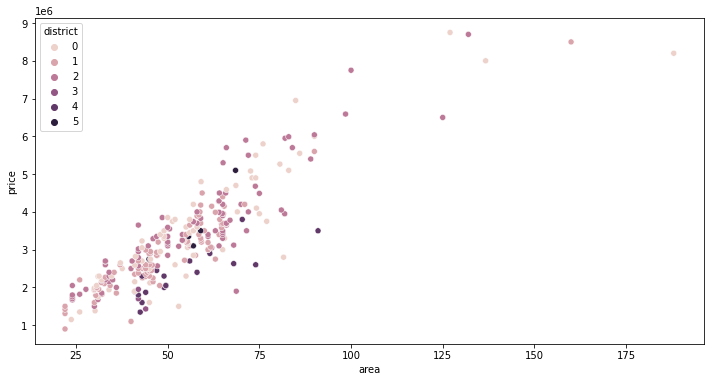

In [8]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='area', y='price', hue='district')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    277 non-null    object 
 1   price      277 non-null    float64
 2   area       277 non-null    float64
 3   rooms      277 non-null    int64  
 4   floor      277 non-null    int64  
 5   condition  277 non-null    int64  
 6   district   277 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 15.3+ KB


Исследуем матрицу корреляции. Наибольшее влияние на цену оказывают, конечно, площадь и количество комнат. Но такве заметно влияет состояние квартиры, не зря включали этот признак.

<AxesSubplot:>

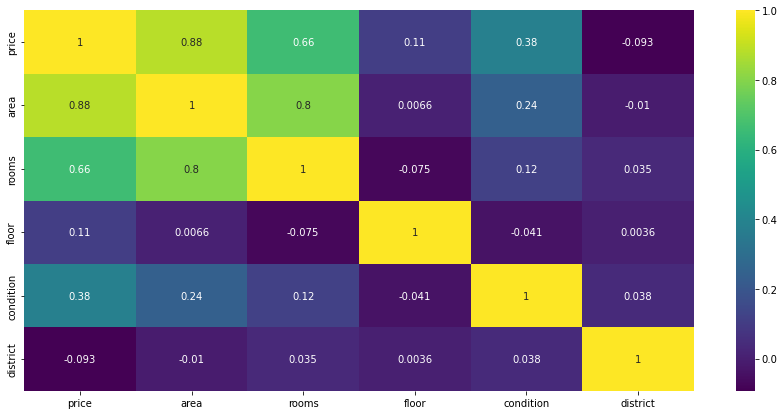

In [10]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

In [11]:
df.head()

,address,price,area,rooms,floor,condition,district
0,"Ленина пр-т, 98/1",900000.0,22.0,1,2,0,1
1,"Ленина пр-т, 93",1100000.0,40.0,1,1,1,1
2,"Первомайская, 26/1",1150000.0,23.7,1,1,2,0
3,"Ленина пр-т, 98/1",1310000.0,22.0,1,3,3,1
4,"Фадеева, 16",1346654.0,42.5,2,3,3,4


Итак, имеем имеем 2 числовых признака (площадь и количество комнат) и 3 категориальных (этаж, состояние квартиры, район), итого 5.

In [12]:
y = df['price']
X = df.iloc[:, list(range(2,7))]
numerical_features = ['area', 'rooms']
categorical_features = ['floor', 'condition', 'district']
pre_cat = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ("cat", OneHotEncoder(), categorical_features)]).fit(X)
X = pre_cat.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=37)
lr_mod = LinearRegression().fit(X_train,y_train)
print('Linear Regression')
print('r2:', r2_score(y_test,lr_mod.predict(X_test)))

Linear Regression
r2: 0.8876451701771881


Теперь, следуя рассмотрению графика цены от площади выше, добавим нелинейность - квадрат от плотности.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn_pandas import DataFrameMapper

In [14]:
X, y = df.iloc[:, list(range(2,7))],df['price']
numerical_features = ['area', 'rooms']
categorical_features = ['floor', 'condition', 'district']
pre_cat = ColumnTransformer(
    transformers=[
        ('num', PolynomialFeatures(degree=2), numerical_features),
        ("cat", OneHotEncoder(), categorical_features)]).fit(X)
X = pre_cat.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=29)
polynomial_regression_model = LinearRegression().fit(X_train,y_train)
   #print(i, r2_score(y_test,lr_mod.predict(X_test)))
print('Polynomial Regression')
print('r2:', r2_score(y_test, polynomial_regression_model.predict(X_test)))

Polynomial Regression
r2: 0.9253249066071462


Сохраняем модель

In [15]:
import pickle
with open('column_transform.pkl', 'wb') as ct:
    pickle.dump(pre_cat, ct)

with open('model.pkl','wb') as f:
    pickle.dump(polynomial_regression_model, f)

In [16]:
#ndf = df.join(pd.DataFrame({'area_squared': df['area']**2}))
ndf = pd.concat([df,pd.DataFrame({'area_squared': df['area']**2})], axis = 1)
ndf.head()

,address,price,area,rooms,floor,condition,district,area_squared
0,"Ленина пр-т, 98/1",900000.0,22.0,1,2,0,1,484.00
1,"Ленина пр-т, 93",1100000.0,40.0,1,1,1,1,1600.00
2,"Первомайская, 26/1",1150000.0,23.7,1,1,2,0,561.69
3,"Ленина пр-т, 98/1",1310000.0,22.0,1,3,3,1,484.00
4,"Фадеева, 16",1346654.0,42.5,2,3,3,4,1806.25


In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pandas as pd
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.offline as pyo
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly_express as px
init_notebook_mode(connected=True)
from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [18]:
y = np.log1p(ndf.price)
#y = ndf.price
X = ndf.drop(['price'], axis=1)
X = X.drop(['address'], axis=1)
X = X.drop(['district'], axis=1)
X = X.drop(['area_squared'], axis=1)
print(X.head())
X.shape, y.shape

   area  rooms  floor  condition
0  22.0      1      2          0
1  40.0      1      1          1
2  23.7      1      1          2
3  22.0      1      3          3
4  42.5      2      3          3


((277, 4), (277,))

In [19]:
pca = PCA(n_components=4).fit(X)
#Plotting the Cumulative Summation of the Explained Variance
expvar=np.cumsum(pca.explained_variance_ratio_)
data = [go.Scatter(y=expvar)]
layout = {'title': 'Review PCA Explained Variance to determine number of components'}
iplot({'data':data,'layout':layout})

In [20]:
pca = PCA(n_components=4)
XPCA = pca.fit_transform(X)

In [21]:
Nc = range(1,20)
kmeans = [KMeans(i) for i in Nc]
score = [kmeans[i].fit(XPCA).score(XPCA) for i in range(len(kmeans))]

In [22]:
data = [go.Scatter(y=score,x=list(Nc))]
layout = {'title':'Review Elbow Curve to determine number of clusters for KMeans'}
iplot({'data':data,'layout':layout})

In [23]:
n_clusters=5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
Xkmeans = kmeans.fit_predict(XPCA)

In [24]:
from sklearn.manifold import TSNE
XTSNE = TSNE(n_components=2).fit_transform(XPCA)

In [25]:
#XTSNEdf = pd.concat([pd.DataFrame(XTSNE),pd.DataFrame(Xkmeans),pd.DataFrame(y),pd.DataFrame(np.expm1(y))],axis=1)
XTSNEdf = pd.concat([pd.DataFrame(XTSNE),pd.DataFrame(Xkmeans),pd.DataFrame(y)],axis=1)
XTSNEdf.columns = ['x1','x2','cluster','price']
px.scatter(XTSNEdf,x='x1',y='x2',color='cluster',color_continuous_scale=px.colors.qualitative.Plotly,title="TSNE visualization of House Clusters",width=800,height=500)

In [27]:
districts = ndf.district
clusters = XTSNEdf.cluster
data = np.zeros((6,6), dtype = 'int32')
for i in range(len(clusters)):
    data[clusters[i],districts[i]] += 1
data

array([[22, 31, 23,  3, 11,  1],
       [14,  2, 15,  0,  2,  0],
       [ 3,  1,  2,  0,  0,  0],
       [14, 20, 20,  0,  0,  0],
       [19, 33, 32,  0,  5,  4],
       [ 0,  0,  0,  0,  0,  0]], dtype=int32)

In [138]:
s, n = 0, 0
for i in range(5):
    for j in range(5):
        n += data[i,j]
        s += j * data[i,j]
    print(i, n, float(s)/n)
    s, n = 0, 0


0 90 1.4444444444444444
1 33 1.2121212121212122
2 6 0.8333333333333334
3 54 1.1111111111111112
4 89 1.3146067415730338
